<a href="https://colab.research.google.com/github/pranjal-pm/New_Employee_Security_System/blob/main/new_Employee_Security_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os

# Create base folder for synthetic data
base_data_folder = "synthetic_data"
os.makedirs(base_data_folder, exist_ok=True)

num_employees = 30
samples_per_employee = 1000  # number of rows per CSV
sampling_interval = 50  # ms between samples

for emp_id in range(1, num_employees+1):
    # Create a subfolder for each employee
    employee_folder = os.path.join(base_data_folder, f"employee{emp_id}")
    os.makedirs(employee_folder, exist_ok=True)

    timestamps = np.arange(0, samples_per_employee*sampling_interval, sampling_interval)

    # Simulate accelerometer data for x, y, z
    # Random walk + slight sinusoidal to mimic gait
    t = np.linspace(0, 10, samples_per_employee)
    accel_x = 0.2 * np.sin(2 * np.pi * 1.5 * t) + 0.02*np.random.randn(samples_per_employee)
    accel_y = 0.3 * np.sin(2 * np.pi * 1.2 * t) + 0.02*np.random.randn(samples_per_employee)
    accel_z = 9.8 + 0.1 * np.sin(2 * np.pi * 2 * t) + 0.02*np.random.randn(samples_per_employee)  # include gravity

    df = pd.DataFrame({
        "timestamp": timestamps,
        "accel_x": accel_x,
        "accel_y": accel_y,
        "accel_z": accel_z
    })

    # Save the CSV file within the employee's subfolder
    df.to_csv(os.path.join(employee_folder, f"data.csv"), index=False)

print(f"Synthetic dataset for {num_employees} employees created in folder '{base_data_folder}' with subfolders per employee.")

Synthetic dataset for 30 employees created in folder 'synthetic_data'.


In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import welch
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

In [3]:
# For deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling1D
from tensorflow.keras.utils import to_categorical

In [4]:
DATA_DIR = '/content/synthetic_data' # <-- change if needed
SAMPLE_RATE = 50 # approximate Hz. If your CSV has timestamps, we'll compute actual sample rate per file.
WINDOW_DURATION = 2.0 # seconds per analysis window
WINDOW_STEP = 1.0 # seconds (overlap)

In [59]:
# ----------------------
# HELPERS: read sensor files
# ----------------------


def read_sensor_file(path):
    """Read a sensor CSV and return dataframe with columns ['time','ax','ay','az'] if possible.
    Attempts to auto-detect common column names. Handles metadata lines.
    """
    try:
        # Try reading assuming metadata lines (like the uploaded file)
        df = pd.read_csv(path, skiprows=3)
    except Exception:
        # Fallback to reading without skipping rows
        df = pd.read_csv(path)

    # lower-case cols
    df.columns = [c.strip().lower() for c in df.columns]

    # find time col
    time_cols = [c for c in df.columns if 'time' in c or 'timestamp' in c]

    # find acceleration cols, trying common names
    acc_x, acc_y, acc_z = None, None, None
    for possible_x in ['acc_x','ax','accelerometer_x','x', 'ax (m/s^2)']:
        if possible_x in df.columns:
            acc_x = possible_x
            break
    for possible_y in ['acc_y','ay','accelerometer_y','y', 'ay (m/s^2)']:
        if possible_y in df.columns:
            acc_y = possible_y
            break
    for possible_z in ['acc_z','az','accelerometer_z','z', 'az (m/s^2)']:
        if possible_z in df.columns:
            acc_z = possible_z
            break

    # fallback: try using first three numeric columns if nothing found
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if acc_x is None or acc_y is None or acc_z is None:
        if len(numeric_cols) >= 3:
            acc_x, acc_y, acc_z = numeric_cols[:3]
    time_col = time_cols[0] if time_cols else None


    if time_col is None:
        # create synthetic time based on sample rate (if available)
        if 'SAMPLE_RATE' in globals():
             df['time'] = np.arange(len(df)) / SAMPLE_RATE
             time_col = 'time'
        else:
            # Cannot create time if no time column and no sample rate defined
            raise ValueError("Could not find time column and SAMPLE_RATE is not defined.")


    # Ensure all required columns are found
    if time_col is None or acc_x is None or acc_y is None or acc_z is None:
         raise ValueError("Could not find all required columns (time, ax, ay, az).")


    df = df.rename(columns={time_col: 'time', acc_x: 'ax', acc_y: 'ay', acc_z: 'az'})
    df = df[['time','ax','ay','az']]
    df = df.dropna()
    return df


In [60]:
# ----------------------
# WINDOWING + FEATURE EXTRACTION
# ----------------------


def sliding_windows(df, window_size_s=WINDOW_DURATION, step_s=WINDOW_STEP):
    """Yield windows as dataframes from df with 'time','ax','ay','az'."""
    times = df['time'].values
    total_dur = times[-1] - times[0]
    if total_dur <= 0:
        return
    fs_est = (len(times)-1) / total_dur
    win_len = int(round(window_size_s * fs_est))
    step = int(round(step_s * fs_est))
    arr = df[['ax','ay','az']].values
    for start in range(0, max(1, len(arr)-win_len+1), max(1,step)):
        yield arr[start:start+win_len]

In [61]:
def extract_features_from_window(win):
    """win: numpy array shape (N,3). Returns a feature vector."""
    if win.shape[0] == 0:
        return None
    ax = win[:,0]
    ay = win[:,1]
    az = win[:,2]
    mag = np.sqrt(ax**2 + ay**2 + az**2)
    feat = {}
    # time domain
    for name, arr in [('ax',ax), ('ay',ay), ('az',az), ('mag',mag)]:
        feat[f'{name}_mean'] = np.mean(arr)
        feat[f'{name}_std'] = np.std(arr)
        feat[f'{name}_min'] = np.min(arr)
        feat[f'{name}_max'] = np.max(arr)
        feat[f'{name}_median'] = np.median(arr)
        feat[f'{name}_iqr'] = np.percentile(arr,75) - np.percentile(arr,25)
        feat[f'{name}_rms'] = np.sqrt(np.mean(arr**2))
        feat[f'{name}_skew'] = stats.skew(arr)
        feat[f'{name}_kurt'] = stats.kurtosis(arr)
    # correlations
    feat['corr_xy'] = np.corrcoef(ax,ay)[0,1]
    feat['corr_xz'] = np.corrcoef(ax,az)[0,1]
    feat['corr_yz'] = np.corrcoef(ay,az)[0,1]
    # frequency domain: dominant freq via FFT
    N = len(mag)
    if N > 1:
        freqs = np.fft.rfftfreq(N, d=1.0/SAMPLE_RATE)
        psd = np.abs(np.fft.rfft(mag))**2
        dom_idx = np.argmax(psd)
        feat['dom_freq'] = freqs[dom_idx]
        feat['spec_entropy'] = -np.sum((psd/psd.sum()) * np.log2((psd/psd.sum())+1e-12))
        feat['spec_energy'] = np.sum(psd)
    else:
        feat['dom_freq'] = 0
        feat['spec_entropy'] = 0
        feat['spec_energy'] = 0
    return feat

In [62]:
# ----------------------
# BUILD DATASET FROM FOLDER
# ----------------------


def build_features_from_folder(data_dir):
    X = []
    y = []
    files_scanned = 0
    for employee_folder in sorted(glob.glob(os.path.join(data_dir, '*'))):
        if not os.path.isdir(employee_folder):
            continue
        label = os.path.basename(employee_folder)
        for csv_file in glob.glob(os.path.join(employee_folder, '*.csv')):
            try:
                df = read_sensor_file(csv_file)
            except Exception as e:
                print(f'Failed to read {csv_file}: {e}')
                continue
            for win in sliding_windows(df):
                feat = extract_features_from_window(win)
                if feat is None:
                    continue
                X.append(list(feat.values()))
                y.append(label)
                files_scanned += 1
    feature_names = list(feat.keys()) if 'feat' in locals() else []
    X = np.array(X)
    y = np.array(y)
    print(f'Scanned {files_scanned} files. Extracted {len(X)} windows.')
    return X, y, feature_names

In [63]:
# ----------------------
# TRAIN CLASSICAL ML: RandomForest
# ----------------------


def train_random_forest(X, y, feature_names, save_path=None):
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=42)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)


    clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    clf.fit(X_train_s, y_train)
    y_pred = clf.predict(X_test_s)
    acc = accuracy_score(y_test, y_pred)
    print('RandomForest Test Accuracy:', acc)
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    if save_path:
        os.makedirs(save_path, exist_ok=True)
        joblib.dump({'model':clf, 'scaler':scaler, 'label_encoder':le, 'features':feature_names}, os.path.join(save_path,'rf_pipeline.joblib'))
        print('Saved RF pipeline to', os.path.join(save_path,'rf_pipeline.joblib'))
    return clf, scaler, le

In [64]:
# ----------------------
# PREPARE RAW WINDOWS FOR CNN
# ----------------------


def build_cnn_dataset(data_dir, window_size_s=WINDOW_DURATION, step_s=WINDOW_STEP, max_windows_per_file=200):
    X = []
    y = []
    for employee_folder in sorted(glob.glob(os.path.join(data_dir, '*'))):
        if not os.path.isdir(employee_folder):
            continue
        label = os.path.basename(employee_folder)
        for csv_file in glob.glob(os.path.join(employee_folder, '*.csv')):
            try:
                df = read_sensor_file(csv_file)
            except:
                continue
            times = df['time'].values
            total_dur = times[-1] - times[0]
            if total_dur <= 0:
                continue
            fs_est = (len(times)-1)/total_dur
            win_len = int(round(window_size_s * fs_est))
            step = int(round(step_s * fs_est))
            arr = df[['ax','ay','az']].values
            count = 0
            for start in range(0, max(1, len(arr)-win_len+1), max(1,step)):
                win = arr[start:start+win_len]
                if win.shape[0] != win_len:
                    continue
                # Normalize window (per-window)
                win = (win - np.mean(win, axis=0)) / (np.std(win, axis=0) + 1e-6)
                X.append(win)
                y.append(label) # Assuming label is the employee folder name
                count += 1
                if count >= max_windows_per_file:
                    break
    X = np.array(X)
    y = np.array(y)
    print(f'Built CNN dataset with {len(X)} windows.')
    return X, y

In [65]:
# ----------------------
# CNN MODEL
# ----------------------


def make_cnn_model(input_shape, n_classes):
    model = Sequential([
        Conv1D(32, kernel_size=5, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(2),
        Conv1D(64, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),
        Conv1D(128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [66]:
# ----------------------
# SAVE/LOAD RF INFERENCE UTILITY
# ----------------------


def rf_predict_from_csv(csv_path, pipeline_path):
    pipe = joblib.load(pipeline_path)
    df = read_sensor_file(csv_path)
    feats = []
    for win in sliding_windows(df):
        f = extract_features_from_window(win)
        feats.append(list(f.values()))
    X = np.array(feats)
    X_s = pipe['scaler'].transform(X)
    preds = pipe['model'].predict(X_s)
    labels = pipe['label_encoder'].inverse_transform(preds)
    # majority vote
    from collections import Counter
    c = Counter(labels)
    return c.most_common(3)

In [68]:
import glob

files = glob.glob("/content/synthetic_data/employee1.csv")
print("Found files:", files[:10])  # print first 10
print("Total CSVs:", len(files))


Found files: ['/content/synthetic_data/employee1.csv']
Total CSVs: 1


In [69]:
DATA_DIR = '/content/synthetic_data'


In [71]:
X, y, feature_names = build_features_from_folder(DATA_DIR)


Scanned 0 files. Extracted 0 windows.


In [72]:
for file in glob.glob("/content/stark-gait-dataset/*.csv"):
    ...


In [74]:
df = read_sensor_file("/content/synthetic_data/employee1.csv")
print(df.head())

   time        ax        ay        az
0     0  0.019909 -0.006202  9.799837
1    50 -0.006458  0.014627  9.822019
2   100  0.055151  0.073891  9.827723
3   150  0.064647  0.084887  9.820165
4   200  0.087804  0.078411  9.865022


In [76]:
SAMPLE_RATE = 20     # based on your time column spacing (50ms interval = 20Hz)
WINDOW_SIZE = SAMPLE_RATE * 2   # 2 seconds = 40 samples

df = read_sensor_file("/content/synthetic_data/employee1.csv")
print("File length:", len(df))

for start in range(0, len(df) - WINDOW_SIZE, SAMPLE_RATE):  # step 1s
    window = df.iloc[start:start+WINDOW_SIZE]
    print("Extracted window:", window.shape)
    break

File length: 1000
Extracted window: (40, 4)


In [77]:
def extract_windows(df, window_seconds=2, step_seconds=1, fixed_window_size=None):
    """
    Slice dataframe into overlapping windows based on detected sample rate or fixed size.

    Args:
        df : DataFrame with ['time','ax','ay','az']
        window_seconds : window length in seconds (used if fixed_window_size is None)
        step_seconds   : step between windows in seconds (used if fixed_window_size is None)
        fixed_window_size: If an integer, use this as the window size in samples.

    Returns:
        list of numpy arrays shaped (window_size, 3)  (ax, ay, az)
    """

    if len(df) < 2:
        return []

    if fixed_window_size is not None:
        window_size = fixed_window_size
        # Assuming step is proportional to window size if fixed size is used, or could be a fixed number of samples
        # For simplicity, let's make step_size also based on a ratio of the fixed window size, or assume step_seconds is still relevant for fixed samples
        # Let's use step_seconds still, calculating step_size based on the detected sample rate for stepping.
        dt = np.median(np.diff(df['time']))
        sample_rate = round(1000.0 / dt) if dt > 1 else round(1.0 / dt)
        step_size = int(step_seconds * sample_rate)

    else:
        # --- Detect sample rate from 'time' column ---
        dt = np.median(np.diff(df['time']))  # spacing between samples
        if dt == 0:  # fallback
            sample_rate = 50 # Default or error
        else:
            # if time in ms → convert to seconds
            if dt > 1:
                sample_rate = round(1000.0 / dt)
            else:
                sample_rate = round(1.0 / dt)

        print(f"Detected sample rate: {sample_rate} Hz")
        window_size = int(window_seconds * sample_rate)
        step_size   = int(step_seconds * sample_rate)


    if len(df) < window_size:
        print(f"⚠️ Not enough samples ({len(df)}) for one window of size {window_size}")
        return []

    windows = []
    # Ensure step_size is at least 1 to avoid infinite loops
    step_size = max(1, step_size)

    for start in range(0, len(df) - window_size + 1, step_size):
        chunk = df.iloc[start:start+window_size][['ax','ay','az']].values
        windows.append(chunk)

    print(f"Extracted {len(windows)} windows of size {window_size}")
    return windows


In [101]:
df = read_sensor_file("/content/synthetic_data/employee1.csv")
windows = extract_windows(df, window_seconds=2, step_seconds=1)

Detected sample rate: 20 Hz
Extracted 49 windows of size 40


In [81]:
def build_cnn_dataset(data_dir, window_seconds=2, step_seconds=1):
    """
    Traverse employee folders → read sensor CSV → slice into windows → build dataset
    """
    X = []
    y = []
    emp_ids = []

    for emp_folder in os.listdir(data_dir):
        emp_path = os.path.join(data_dir, emp_folder)
        if not os.path.isdir(emp_path):
            continue

        for file in os.listdir(emp_path):
            if not file.endswith(".csv"):
                continue

            df = read_sensor_file(os.path.join(emp_path, file))
            windows = extract_windows(df, window_seconds, step_seconds)

            for w in windows:
                X.append(w)
                y.append(emp_folder)  # use folder name as employee label
                emp_ids.append(emp_folder)

    X = np.array(X)
    y = np.array(y)

    print(f"Built dataset: {X.shape[0]} windows, shape={X.shape}, employees={len(set(y))}")
    return X, y


In [107]:
# ---------------------------
# Stark Industries Gait Recognition - Full Pipeline
# ---------------------------

# 1️⃣ Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2️⃣ Imports
import os, glob
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

# ---------------------------
# 3️⃣ Helper functions
# ---------------------------

def read_sensor_file(path):
    """Read a sensor CSV and return dataframe with ['time','ax','ay','az']"""
    df = pd.read_csv(path)
    df = df.rename(columns={
        'timestamp': 'time',
        'accel_x': 'ax',
        'accel_y': 'ay',
        'accel_z': 'az'
    })
    df = df[['time','ax','ay','az']].dropna()
    return df

def extract_windows(df, window_seconds=2, step_seconds=1):
    """Slice dataframe into overlapping windows"""
    if len(df) < 2:
        return []
    dt = np.median(np.diff(df['time']))
    # detect sampling rate
    sample_rate = round(1000.0 / dt) if dt > 1 else round(1.0 / dt)
    window_size = int(window_seconds * sample_rate)
    step_size   = int(step_seconds * sample_rate)
    if len(df) < window_size:
        return []
    windows = []
    for start in range(0, len(df) - window_size + 1, step_size):
        chunk = df.iloc[start:start+window_size][['ax','ay','az']].values
        windows.append(chunk)
    return windows

# ---------------------------
# 4️⃣ Build dataset
# ---------------------------

DATA_DIR = "/content/drive/MyDrive/stark-gait-dataset"  # <- update your folder path here

X, y = [], []

emp_folders = [f for f in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR,f))]
print(f"Found {len(emp_folders)} employee folders.")

for emp in emp_folders:
    emp_path = os.path.join(DATA_DIR, emp)
    files = glob.glob(os.path.join(emp_path, "*.csv"))
    print(f"Processing {emp} with {len(files)} files...")
    for f in files:
        df = read_sensor_file(f)
        windows = extract_windows(df, window_seconds=2, step_seconds=1)
        for w in windows:
            X.append(w)
            y.append(emp)

X = np.array(X)
y = np.array(y)
print(f"Total windows: {X.shape[0]}, Window shape: {X[0].shape if X.shape[0]>0 else 'N/A'}")

# ---------------------------
# 5️⃣ Encode labels
# ---------------------------
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
print("Employees:", encoder.classes_)

# ---------------------------
# 6️⃣ Train/Test split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)
print("Train windows:", X_train.shape[0], "Test windows:", X_test.shape[0])

# ---------------------------
# 7️⃣ CNN model
# ---------------------------
def build_gait_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv1D(32, 3, activation='relu', input_shape=input_shape),
        layers.MaxPooling1D(2),
        layers.Conv1D(64, 3, activation='relu'),
        layers.MaxPooling1D(2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_gait_cnn((X_train.shape[1], X_train.shape[2]), len(np.unique(y_encoded)))
model.summary()

# ---------------------------
# 8️⃣ Train
# ---------------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)

# ---------------------------
# 9️⃣ Evaluate
# ---------------------------
loss, acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {acc*100:.2f}%")

# ---------------------------
# 10️⃣ Predict new employee
# ---------------------------
def predict_employee(model, window, encoder):
    pred = model.predict(window[np.newaxis,...])
    return encoder.inverse_transform([np.argmax(pred)])[0]

# Example:
# df_new = read_sensor_file("/content/drive/MyDrive/stark-gait-dataset/employee1.csv")
# new_window = extract_windows(df_new, window_seconds=2, step_seconds=1)[0]
# print("Predicted employee:", predict_employee(model, new_window, encoder))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/stark-gait-dataset'

In [105]:
!ls /content/drive/MyDrive


 batman
'Colab Notebooks'
 ecoo.pdf
 Fast-Dreambooth
'Google AI Studio'
'Google Keep Document.gdoc'
'Gray and White Simple Clean Resume (1).pdf'
'Paper  3.docx'
 pexels-ash-craig-122861-376464.jpg
'Pranjal23 (1).pdf'
'Pranjal23 (2).pdf'
'Pranjal23 (3).pdf'
 Pranjal23.pdf
'PRANJAL CV (2) (1).pdf'
'PRANJAL CV (2) (2).pdf'
'PRANJAL CV (2) (3).pdf'
'PRANJAL CV (2).pdf'
'PRANJAL CV (3).pdf'
'Pranjal Maheshwari_offer_letternew.pdf'
'pranjal maheshwari RESUME.docx'
 PRANJAL.pdf
'pranjal resume_____ (1).pdf'
'pranjal resume_____ (2).pdf'
'PRANJAL RESUME (2).pdf'
'PRANJAL RESUME (5) (1).pdf'
'PRANJAL RESUME (5).pdf'
'pranjal resume_____.pdf'
'Pranjal  Resume.pdf'
'PRANJAL RESUME......pdf'
'Problem Statement #3: The Bollywood Movie Analysi... (1).gsheet'
'Problem Statement #3: The Bollywood Movie Analysi....gsheet'
 reply.mp4
'RESUME100 (1).pdf'
 RESUME100.pdf
 Resume.gdoc
'Screenshot 2025-07-04 001745.png'
'Untitled folder'
'Untitled presentation.gslides'
'WhatsApp Image 2024-11-11 at 17.28.12_

In [104]:
from google.colab import files
uploaded = files.upload()  # This will open a file picker


Saving synthetic_data.zip to synthetic_data.zip


In [106]:
# 1️⃣ Unzip the dataset
import zipfile
import os

zip_path = "/content/synthetic_data.zip"
extract_path = "/content/synthetic_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Files extracted to:", extract_path)
print(os.listdir(extract_path))  # should show employee folders


Files extracted to: /content/synthetic_data
['employee17.csv', 'employee4.csv', 'employee24.csv', 'employee7.csv', 'employee27.csv', 'employee8.csv', 'employee12.csv', 'employee6.csv', 'employee3.csv', 'employee1.csv', 'employee21.csv', 'employee23.csv', 'employee30.csv', 'employee28.csv', 'employee13.csv', 'employee29.csv', 'employee11.csv', 'employee9.csv', 'employee26.csv', 'employee18.csv', 'employee15.csv', 'employee2.csv', 'employee10.csv', 'employee5.csv', 'employee20.csv', 'employee16.csv', 'employee19.csv', 'employee25.csv', 'employee22.csv', 'employee14.csv']


In [108]:
# 1️⃣ Unzip the dataset
import zipfile
import os

zip_path = "/content/synthetic_data.zip"
extract_path = "/content/synthetic_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Files extracted to:", extract_path)
print(os.listdir(extract_path))  # should show employee folders


Files extracted to: /content/synthetic_data
['employee17.csv', 'employee4.csv', 'employee24.csv', 'employee7.csv', 'employee27.csv', 'employee8.csv', 'employee12.csv', 'employee6.csv', 'employee3.csv', 'employee1.csv', 'employee21.csv', 'employee23.csv', 'employee30.csv', 'employee28.csv', 'employee13.csv', 'employee29.csv', 'employee11.csv', 'employee9.csv', 'employee26.csv', 'employee18.csv', 'employee15.csv', 'employee2.csv', 'employee10.csv', 'employee5.csv', 'employee20.csv', 'employee16.csv', 'employee19.csv', 'employee25.csv', 'employee22.csv', 'employee14.csv']


In [110]:
emp_folders = [f for f in os.listdir(extract_path) if os.path.isdir(os.path.join(extract_path,f))]


In [111]:
import glob
import numpy as np
import pandas as pd
import os

# Reuse helper functions
def read_sensor_file(path):
    df = pd.read_csv(path)
    df = df.rename(columns={
        'timestamp': 'time',
        'accel_x': 'ax',
        'accel_y': 'ay',
        'accel_z': 'az'
    })
    df = df[['time','ax','ay','az']].dropna()
    return df

def extract_windows(df, window_seconds=2, step_seconds=1):
    if len(df) < 2:
        return []
    dt = np.median(np.diff(df['time']))
    sample_rate = round(1000.0 / dt) if dt > 1 else round(1.0 / dt)
    window_size = int(window_seconds * sample_rate)
    step_size   = int(step_seconds * sample_rate)
    if len(df) < window_size:
        return []
    windows = []
    for start in range(0, len(df) - window_size + 1, step_size):
        chunk = df.iloc[start:start+window_size][['ax','ay','az']].values
        windows.append(chunk)
    return windows

# Build dataset from all CSVs directly in the extracted folder
X, y = [], []

csv_files = glob.glob(os.path.join(extract_path, "*.csv"))
print(f"Found {len(csv_files)} CSV files.")

for f in csv_files:
    df = read_sensor_file(f)
    windows = extract_windows(df, window_seconds=2, step_seconds=1)
    label = os.path.basename(f).split(".")[0]  # use filename as employee label
    for w in windows:
        X.append(w)
        y.append(label)

X = np.array(X)
y = np.array(y)
print(f"Total windows: {X.shape[0]}, Window shape: {X[0].shape if X.shape[0]>0 else 'N/A'}")


Found 30 CSV files.
Total windows: 1470, Window shape: (40, 3)


In [112]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

print("Employees:", encoder.classes_)


Employees: ['employee1' 'employee10' 'employee11' 'employee12' 'employee13'
 'employee14' 'employee15' 'employee16' 'employee17' 'employee18'
 'employee19' 'employee2' 'employee20' 'employee21' 'employee22'
 'employee23' 'employee24' 'employee25' 'employee26' 'employee27'
 'employee28' 'employee29' 'employee3' 'employee30' 'employee4'
 'employee5' 'employee6' 'employee7' 'employee8' 'employee9']


In [113]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

print("Train windows:", X_train.shape[0], "Test windows:", X_test.shape[0])


Train windows: 1176 Test windows: 294


In [114]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_gait_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv1D(32, 3, activation='relu', input_shape=input_shape),
        layers.MaxPooling1D(2),
        layers.Conv1D(64, 3, activation='relu'),
        layers.MaxPooling1D(2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_gait_cnn((X_train.shape[1], X_train.shape[2]), len(encoder.classes_))
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 38, 32)         │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 19, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 17, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,062 (297.12 KB)

 Trainable params: 76,062 (297.12 KB)

 Non-trainable params: 0 (0.00 B)

In [115]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)


Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.0417 - loss: 3.5425 - val_accuracy: 0.0408 - val_loss: 3.4182
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0255 - loss: 3.4110 - val_accuracy: 0.0204 - val_loss: 3.4032
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0315 - loss: 3.4059 - val_accuracy: 0.0170 - val_loss: 3.4125
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0482 - loss: 3.3993 - val_accuracy: 0.0136 - val_loss: 3.4129
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0356 - loss: 3.4027 - val_accuracy: 0.0238 - val_loss: 3.4169
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0446 - loss: 3.3981 - val_accuracy: 0.0204 - val_loss: 3.4159
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.0402 - loss: 3.4010 - val_accuracy: 0.0068 - val_loss: 3.4108
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0381 - loss: 3.4013 - val_accuracy: 0.0204 - val_

In [116]:
loss, acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {acc*100:.2f}%")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0131 - loss: 3.4159     
✅ Test Accuracy: 1.36%


In [117]:
def predict_employee(model, window, encoder):
    pred = model.predict(window[np.newaxis, ...])
    return encoder.inverse_transform([np.argmax(pred)])[0]

# Example:
# new_df = read_sensor_file("/content/synthetic_data/employee1.csv")
# new_window = extract_windows(new_df, window_seconds=2, step_seconds=1)[0]
# print("Predicted employee:", predict_employee(model, new_window, encoder))


In [118]:
model.save("/content/gait_cnn_model.h5")
print("Model saved!")


Model saved!


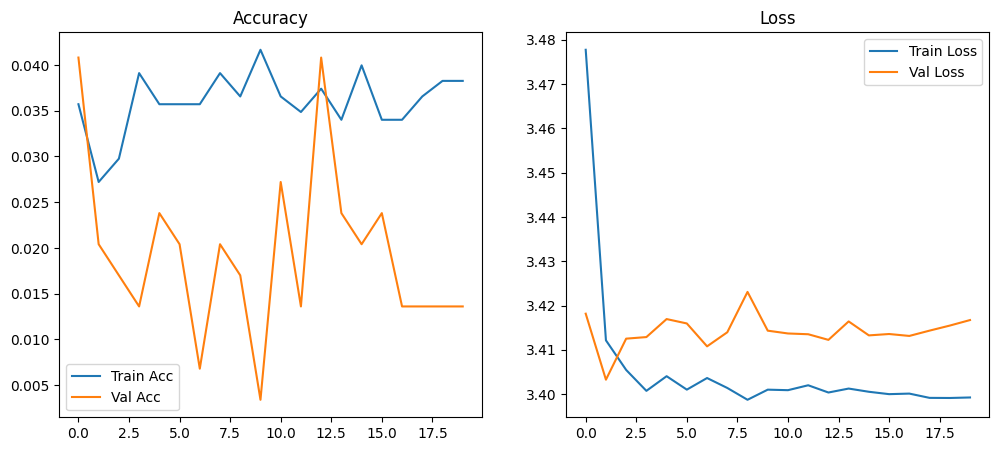

In [119]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.show()


In [151]:
from google.colab import files
uploaded = files.upload()  # Select your CSV file(s)



Saving linear_acceleration_2025-09-27_09.08.04.csv to linear_acceleration_2025-09-27_09.08.04.csv


In [152]:
# 1️⃣ Read the CSV
new_df = read_sensor_file_pt("/content/linear_acceleration_2025-09-27_09.08.04.csv")
print("CSV loaded, number of rows:", len(new_df))

# 2️⃣ Extract windows (2 seconds each, step 1 second)
windows = extract_windows(new_df, window_seconds=2, step_seconds=1)
print("Total windows extracted:", len(windows))

# 3️⃣ Pad/truncate windows to match training size
train_window_size = X_train.shape[1]
padded_windows = []
for w in windows:
    current_len = w.shape[0]
    if current_len < train_window_size:
        pad_len = train_window_size - current_len
        w_padded = np.vstack([w, np.zeros((pad_len, w.shape[1]))])
        padded_windows.append(w_padded)
    elif current_len > train_window_size:
        padded_windows.append(w[:train_window_size])
    else:
        padded_windows.append(w)

print("Windows ready for prediction:", len(padded_windows))

# 4️⃣ Predict employee
predictions = [predict_employee(model, w, encoder) for w in padded_windows]

from collections import Counter
if len(predictions) == 0:
    print("❌ No valid predictions. Recording may still be too short.")
else:
    final_prediction = Counter(predictions).most_common(1)[0][0]
    print("✅ Final Predicted Employee:", final_prediction)


CSV loaded, number of rows: 527
Total windows extracted: 4
Windows ready for prediction: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
✅ Final Predicted Employee: employee25
